In [1]:
#import numba #The code will get messy if we import numba completely
from numba import (cuda,  
                   int32,
                   float64,
                   float32,
                   jit, 
                   vectorize)

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import time

In [2]:
## define alpha
alpha=1.11*(10**(-4))#*100

## define x
nx=5000
x=np.linspace(0,1,nx)
dx=x[1]-x[0]

## define t
nt=100
t=np.linspace(0,10,nt)
dt=t[1]-t[0]

## Numpy basics

In [3]:
%%time 
## define T with zeros
T=np.zeros((nx,nt),dtype=np.float64)

## Initial condition
T[:,0]=300.

### define A
A=np.zeros((nx,nx),dtype=np.float64)

C=alpha*dt/(dx**2)
for i in range(1,nx-1):
    A[i,i]=-(2.*C+1.)
    A[i,i+1]=C
    A[i,i-1]=C

#define off-diagonal elements of A
    A[0,0]=1.
    A[-1,-1]=1.

for k in range(0,nt-1):
    #define b
    b=np.zeros((nx,),dtype=np.float64)
    b[0]=400.
    b[-1]=300.
    for i in range(1,nx-1):
        b[i]=-T[i,k]
    
    #calculate T
    T[:,k+1]=np.linalg.solve(A,b)

CPU times: user 1min 51s, sys: 3.81 s, total: 1min 55s
Wall time: 1min 55s


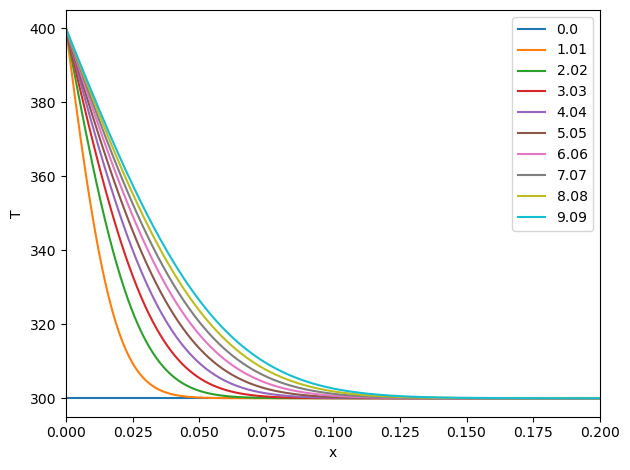

In [4]:
fig, ax=plt.subplots(1,1)
for k in range(0,nt,int(nt/10)):
	ax.plot(x,T[:,k], label=str(k*dt)[:4]);
ax.set_xlabel('x');
ax.set_ylabel('T')
ax.set_xlim([0,0.2])
fig.tight_layout()
plt.legend()
plt.show()

## cuda jit

In [5]:
@cuda.jit
def fillA(A, C):
    i = cuda.grid(1)
    if 1 <= i < A.shape[0] - 1:
        A[i, i] = -(2. * C + 1.)
        A[i, i + 1] = C
        A[i, i - 1] = C
    elif i==0:
        A[i,i]=1.
    elif i==A.shape[0]-1:
        A[i,i]=1.

In [10]:
@cuda.jit
def calcb(b,T,k):
    i=cuda.grid(1)
    if 1 <= i < b.shape[0] - 1:
        b[i]=-T[i]
    elif i==0:
        b[i]=400.
    elif i==b.shape[0]-1:
        b[i]=300.        

In [11]:
%%time 
## define T with zeros
T_gpu=cp.zeros((nx,nt),dtype=np.float64)+300.

### define A
A_gpu=cp.zeros((nx,nx),dtype=np.float64)
C=alpha*dt/(dx**2)

# Threads per block and blocks per grid
threads_per_block = 128
blocks_per_grid = (A_gpu.shape[0] + (threads_per_block - 1)) // threads_per_block

fillA[blocks_per_grid, threads_per_block](A_gpu,C)

for k in range(0,nt-1):
    #define b
    b_gpu=cp.zeros((nx,),dtype=np.float64)
    Tp=T_gpu[:,k]
    calcb[blocks_per_grid, threads_per_block](b_gpu,Tp,k)
    
    #calculate T
    T_gpu[:,k+1]=cp.linalg.solve(A_gpu,b_gpu)

/home1/irahbari/.conda/envs/focexgpu/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU times: user 2.72 s, sys: 1.3 s, total: 4.02 s
Wall time: 4.03 s


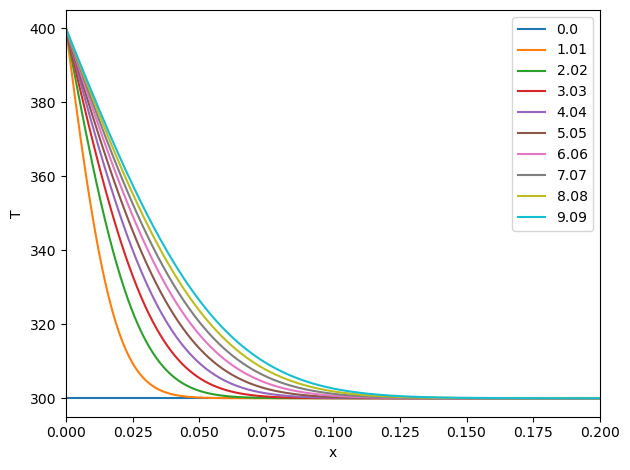

In [12]:
fig, ax=plt.subplots(1,1)
for k in range(0,nt,int(nt/10)):
	ax.plot(x,cp.asnumpy(T_gpu[:,k]), label=str(k*dt)[:4]);
ax.set_xlabel('x');
ax.set_ylabel('T')
ax.set_xlim([0,0.2])
fig.tight_layout()
plt.legend()
plt.show()